## Work
1. 請自行定義一個 loss function, 為 0.3 * focal loss + 0.7 cross-entropy，訓練並比較結果


In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 25
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [7]:
import tensorflow as tf
import keras.backend as K

"""Code Here
撰寫一個 loss function, 使其可以結合 focal loss 與 crossentropy loss
"""

def focal_loss(y_true, y_pred, gamma=2., alpha=4.):
    gamma = float(gamma)
    alpha = float(alpha)
    
    """Focal loss for multi-classification
    FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
    """
    epsilon = 1e-8
    y_true = tf.convert_to_tensor(y_true, tf.float32)
    y_pred = tf.convert_to_tensor(y_pred, tf.float32)

    model_out = tf.add(y_pred, epsilon)
    ce = tf.multiply(y_true, -tf.log(model_out))
    weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
    fl = tf.multiply(alpha, tf.multiply(weight, ce))
    reduced_fl = tf.reduce_max(fl, axis=1)
    return tf.reduce_mean(reduced_fl)

def cross_entropy(y_true, y_pred):
    return keras.losses.categorical_crossentropy(y_true, y_pred)

def combined_loss(ce_weights):
    ce_weights = float(ce_weights)
    
    def cm_loss_fixed(y_true, y_pred):
    
        focal = tf.scalar_mul(ce_weights, focal_loss(y_true, y_pred))
        cross_en = tf.scalar_mul((1-ce_weights), cross_entropy(y_true, y_pred))
        cm_loss = tf.add(focal, cross_en)
        return cm_loss
        
    return cm_loss_fixed
    
ce_weights_list = [0., 0.3, 0.5, 0.7, 1]

In [8]:
import itertools
results = {}

for i, ce_w in enumerate(ce_weights_list):
    print("Numbers of exp: %i, ce_weight: %.2f" % (i, ce_w))

    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    
    model.compile(loss=combined_loss(ce_w), metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True
             )
    
    # Collect results
    exp_name_tag = ("exp-%s: %.1f * facal_loss + %.1f * cross_entropy" % (i+1, ce_w, 1-ce_w))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

W0730 19:28:06.850708 21132 deprecation_wrapper.py:119] From D:\Anaconda3\envs\keras37\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0730 19:28:06.862519 21132 deprecation_wrapper.py:119] From D:\Anaconda3\envs\keras37\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0730 19:28:06.862519 21132 deprecation_wrapper.py:119] From D:\Anaconda3\envs\keras37\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0730 19:28:06.907065 21132 deprecation_wrapper.py:119] From D:\Anaconda3\envs\keras37\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0730 19:28:07.017131 21132 deprecation_wr

Numbers of exp: 0, ce_weight: 0.00
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128) 

W0730 19:28:07.113291 21132 deprecation.py:323] From D:\Anaconda3\envs\keras37\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 3s 56us/step - loss: 2.2465 - acc: 0.2662 - val_loss: 2.0775 - val_acc: 0.3229
Epoch 2/25
50000/50000 [==============================] - 1s 26us/step - loss: 1.7534 - acc: 0.3895 - val_loss: 1.8128 - val_acc: 0.3740
Epoch 3/25
50000/50000 [==============================] - 1s 27us/step - loss: 1.6194 - acc: 0.4320 - val_loss: 1.6831 - val_acc: 0.4141
Epoch 4/25
50000/50000 [==============================] - 1s 27us/step - loss: 1.5442 - acc: 0.4594 - val_loss: 1.6287 - val_acc: 0.4251
Epoch 5/25
50000/50000 [==============================] - 1s 27us/step - loss: 1.4903 - acc: 0.4785 - val_loss: 1.5877 - val_acc: 0.4390
Epoch 6/25
50000/50000 [==============================] - 1s 27us/step - loss: 1.4454 - acc: 0.4944 - val_loss: 1.5668 - val_acc: 0.4456
Epoch 7/25
50000/50000 [==============================] - 1s 26us/step - loss: 1.4067 - acc: 0.5088 - val_loss: 1.5388 - val_acc

50000/50000 [==============================] - 1s 26us/step - loss: 1.0678 - acc: 0.7422 - val_loss: 2.3225 - val_acc: 0.4868
Epoch 25/25
50000/50000 [==============================] - 1s 27us/step - loss: 1.0292 - acc: 0.7530 - val_loss: 2.3336 - val_acc: 0.4898
Numbers of exp: 2, ce_weight: 0.50
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_7 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_8 (Batch (None, 256) 

50000/50000 [==============================] - 1s 26us/step - loss: 2.1551 - acc: 0.6271 - val_loss: 3.2729 - val_acc: 0.4770
Epoch 13/25
50000/50000 [==============================] - 1s 26us/step - loss: 2.0593 - acc: 0.6419 - val_loss: 3.2744 - val_acc: 0.4761
Epoch 14/25
50000/50000 [==============================] - 1s 26us/step - loss: 1.9681 - acc: 0.6556 - val_loss: 3.1871 - val_acc: 0.4915
Epoch 15/25
50000/50000 [==============================] - 1s 27us/step - loss: 1.8839 - acc: 0.6655 - val_loss: 3.2790 - val_acc: 0.4831
Epoch 16/25
50000/50000 [==============================] - 1s 27us/step - loss: 1.7953 - acc: 0.6776 - val_loss: 3.2132 - val_acc: 0.4923
Epoch 17/25
50000/50000 [==============================] - 1s 26us/step - loss: 1.7104 - acc: 0.6924 - val_loss: 3.2775 - val_acc: 0.4830
Epoch 18/25
50000/50000 [==============================] - ETA: 0s - loss: 1.6303 - acc: 0.703 - 1s 26us/step - loss: 1.6317 - acc: 0.7032 - val_loss: 3.2711 - val_acc: 0.4907
Epoch 19

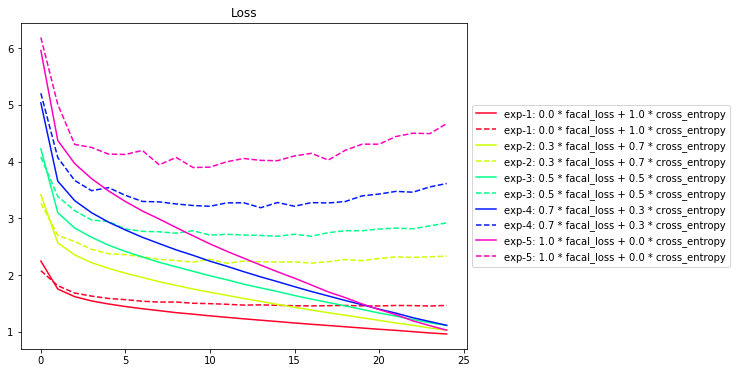

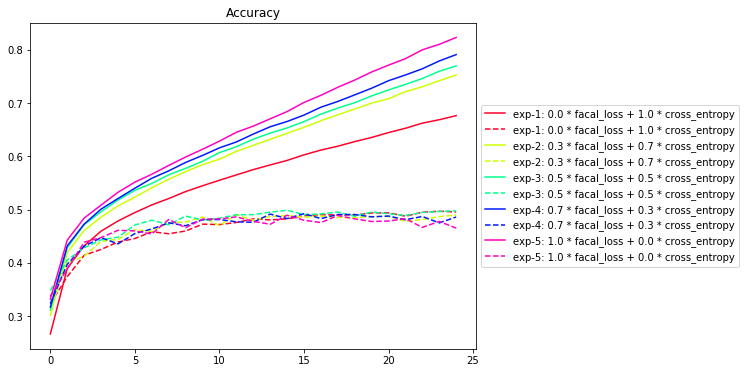

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()